In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
from pmdarima.arima import auto_arima
import re
import seaborn as sns

plt.style.use("ggplot")

import os
os.makedirs("figures", exist_ok=True)

## Data

In [100]:
data = pd.read_csv("DataAssignment3.csv")

government = data.Government
data["NumberWordsLog"] = np.log(data.NumberWords)
data["NumberWordsDiff1"] = data["NumberWords"] - np.roll(data["NumberWords"], 1, axis=0)
data["NumberWordsDiff1"][0] = np.NaN
data["NumberWordsDiff2"] = data["NumberWordsDiff1"] - np.roll(data["NumberWordsDiff1"], 1, axis=0)
data["NumberWordsLogDiff1"] = data["NumberWordsLog"] - np.roll(data["NumberWordsLog"], 1, axis=0)
data["NumberWordsLogDiff2"] = data["NumberWordsLogDiff1"] - np.roll(data["NumberWordsLogDiff1"], 1, axis=0)
# data["NumberWordsDiff1Log"] = np.log(data["NumberWordsDiff1"])
# data["NumberWordsDiff2Log"] = np.log(data["NumberWordsDiff2"])

data = pd.get_dummies(data)
data    

,Date,NumberWords,NumberWordsLog,NumberWordsDiff1,NumberWordsDiff2,NumberWordsLogDiff1,NumberWordsLogDiff2,NumberWordsDiff1Log,NumberWordsDiff2Log,Government_Conservative,Government_Independent,Government_Social Democrats,Government_Social Liberals,Government_Venstre
0,1919,156684,11.961986,NaN,NaN,-5.282254,-5.312076,NaN,NaN,0,0,0,1,0
1,1920,170624,12.047218,13940.0,NaN,0.085231,5.367485,9.542518,NaN,0,0,0,0,1
2,1921,173917,12.066333,3293.0,-10647.0,0.019116,-0.066115,8.099554,NaN,0,0,0,0,1
3,1922,190745,12.158693,16828.0,13535.0,0.092359,0.073243,9.730799,9.513034,0,0,0,0,1
4,1923,192954,12.170207,2209.0,-14619.0,0.011514,-0.080845,7.700295,NaN,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2016,26999144,17.111316,1092379.0,1534740.0,0.041301,0.058232,13.903868,14.243872,0,0,0,0,1
98,2017,27356201,17.124454,357057.0,-735322.0,0.013138,-0.028163,12.785651,NaN,0,0,0,0,1
99,2018,29523506,17.200697,2167305.0,1810248.0,0.076244,0.063105,14.588995,14.408974,0,0,0,0,1
100,2019,29931409,17.214419,407903.0,-1759402.0,0.013722,-0.062522,12.918785,NaN,0,0,1,0,0


Text(0.5, 1.0, 'Number of Words Log Diff 2')

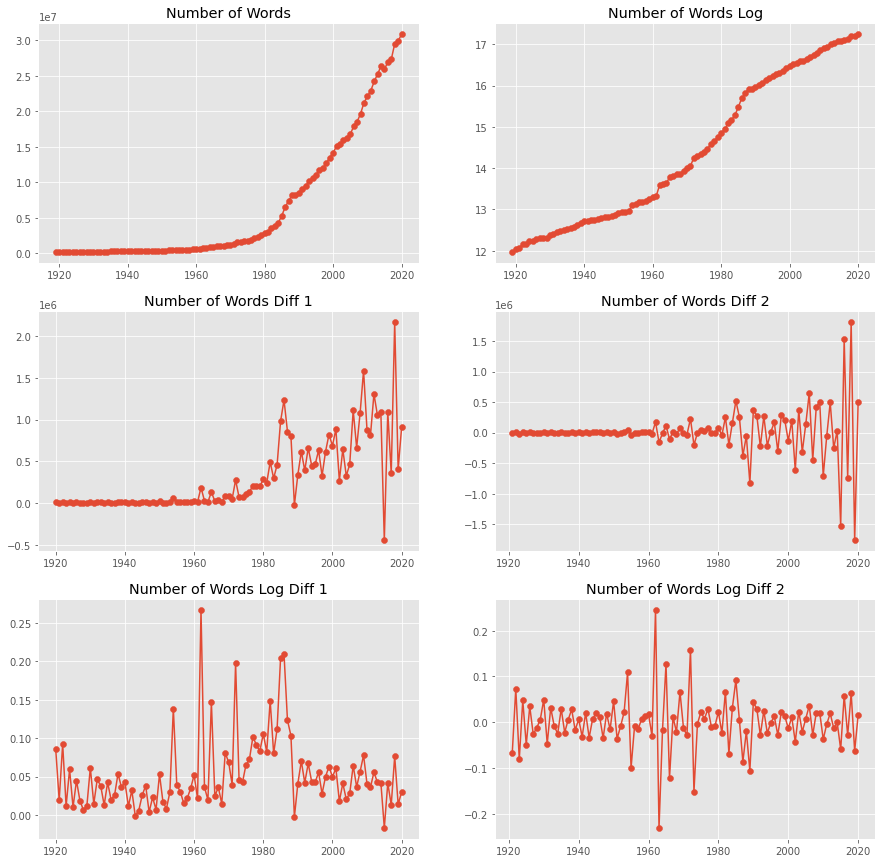

In [101]:
fig, ax = plt.subplots(3,2, figsize=(15,15))

# plot number words
ax[0,0].plot(data.Date, data.NumberWords)
ax[0,0].scatter(data.Date, data.NumberWords)
ax[0,0].set_title("Number of Words")

# plot number words log
ax[0,1].plot(data.Date, data.NumberWordsLog)
ax[0,1].scatter(data.Date, data.NumberWordsLog)
ax[0,1].set_title("Number of Words Log")

# plot number words diff 1
ax[1,0].plot(data.Date[1:], data.NumberWordsDiff1[1:])
ax[1,0].scatter(data.Date[1:], data.NumberWordsDiff1[1:])
ax[1,0].set_title("Number of Words Diff 1")

# plot number words diff 2
ax[1,1].plot(data.Date[2:], data.NumberWordsDiff2[2:])
ax[1,1].scatter(data.Date[2:], data.NumberWordsDiff2[2:])
ax[1,1].set_title("Number of Words Diff 2")

# plot number words log diff 1
ax[2,0].plot(data.Date[1:], data.NumberWordsLogDiff1[1:])
ax[2,0].scatter(data.Date[1:], data.NumberWordsLogDiff1[1:])
ax[2,0].set_title("Number of Words Log Diff 1")

# plot number words log diff 2
ax[2,1].plot(data.Date[2:], data.NumberWordsLogDiff2[2:])
ax[2,1].scatter(data.Date[2:], data.NumberWordsLogDiff2[2:])
ax[2,1].set_title("Number of Words Log Diff 2")

# # plot number words diff 1 log
# ax[3,0].plot(data.Date[1:], data.NumberWordsDiff1Log[1:])
# ax[3,0].scatter(data.Date[1:], data.NumberWordsDiff1Log[1:])
# ax[3,0].set_title("Number of Words Diff 1 Log")

# # plot number words diff 2 log
# ax[3,1].plot(data.Date[2:], data.NumberWordsDiff2Log[2:])
# ax[3,1].scatter(data.Date[2:], data.NumberWordsDiff2Log[2:])
# ax[3,1].set_title("Number of Words Diff 2 Log")

## Fit ARIMA

In [152]:
# !pip install pmdarima 


reg_cols = [s for s in data.columns if re.match("Government", s) is not None]

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
  
# Fit auto_arima function 
model = auto_arima(data['NumberWordsLog'], start_p = 0, start_q = 0,
                          max_p = 10, max_q = 10, max_d = 2,
                          d = None, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True, # set to stepwise
                          X = data[reg_cols]
                          )           
  
# To print the summary
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-325.041, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-332.575, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-329.812, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.019, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-335.837, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-342.288, Time=0.48 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-340.295, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-340.283, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-339.509, Time=0.42 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-338.295, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-337.000, Time=0.39 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 3.653 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  102
Model:               SARIMAX(3, 1, 0)   Log Likelihood                 181.144
Date:                Thu, 14 Apr 2022   AIC                           -342.288
Time:                        13:07:45   BIC                           -316.137
Sample:                             0   HQIC                          -331.701
                                - 102                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercept                       0.0187      0.010      1.885      0.059      -0.001       0.038
Government_Conservative        -0.0073      0.032     -0.224      0.823      -0.071       0.056
Government_Independent          0.0114      0.036      0.314      0.753      -0.060       0.082
Government_Social Democrats     0.0304      0.013      2.363      0.018       0.005       0.056
Government_Social Liberals     -0.0559      0.022     -2.538      0.011      -0.099      -0.013
Government_Venstre              0.0173      0.015      1.166      0.244      -0.012       0.046
ar.L1                           0.1807      0.089      2.030      0.042       0.006       0.355
ar.L2                           0.1546      0.104      1.488      0.137      -0.049       0.358
ar.L3                           0.2912      0.089      3.267      0.001       0.117       0.466
sigma2                          0.0016      0.000     11.720      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               429.89
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             1.91
Prob(H) (two-sided):                  0.22   Kurtosis:                        12.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.13e+16. Standard errors may be unstable.
"""

In [192]:
model.pvalues()

intercept                      5.943315e-02
Government_Conservative        8.227662e-01
Government_Independent         7.531424e-01
Government_Social Democrats    1.810469e-02
Government_Social Liberals     1.114436e-02
Government_Venstre             2.437308e-01
ar.L1                          4.237540e-02
ar.L2                          1.367107e-01
ar.L3                          1.085830e-03
sigma2                         1.006275e-31
dtype: float64

## Interpret params 

In [171]:
pd.DataFrame({"params":model.params(), "exp(params)":np.exp(model.params())})

,params,exp(params)
intercept,0.018684,1.018859
Government_Conservative,-0.007277,0.992749
Government_Independent,0.011385,1.011450
Government_Social Democrats,0.030354,1.030819
Government_Social Liberals,-0.055907,0.945628
Government_Venstre,0.017254,1.017403
ar.L1,0.180694,1.198049
ar.L2,0.154634,1.167231
ar.L3,0.291169,1.337991
sigma2,0.001613,1.001615


### Manual in sample predictions

Text(0.5, 1.0, '1-step predictions')

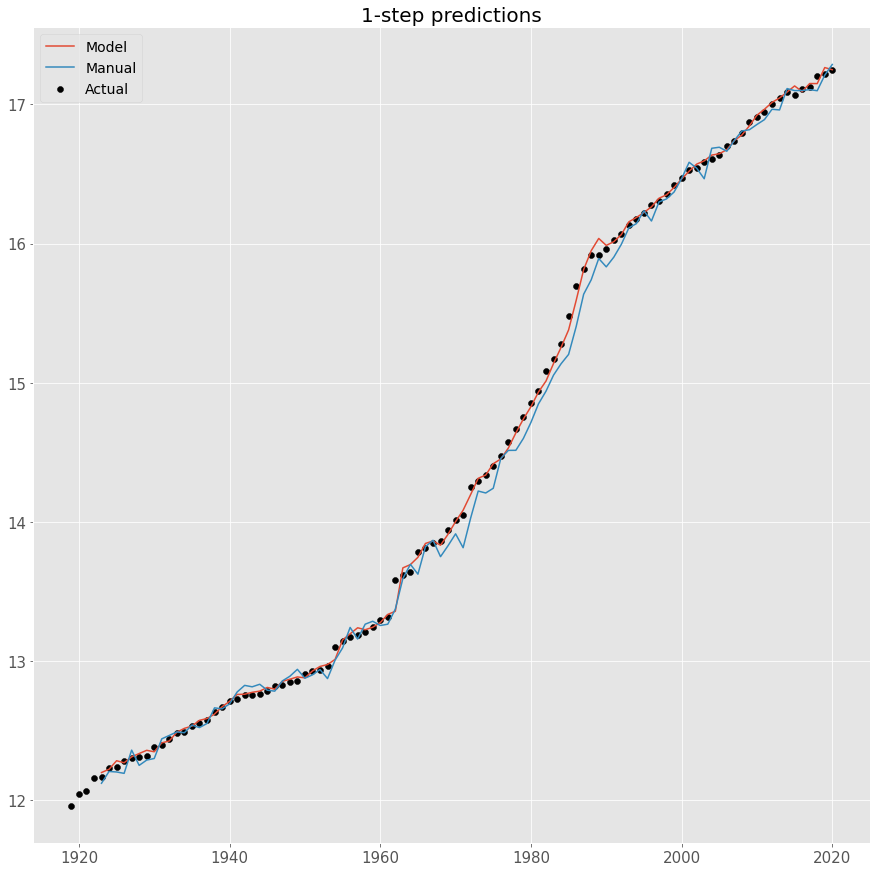

In [325]:
params = model.params()
phi1 = params.get("ar.L1", 0) #* (model.pvalues().get("ar.L1", 1) < 0.05)
phi2 = params.get("ar.L2", 0) #* (model.pvalues().get("ar.L2", 1) < 0.05)
phi3 = params.get("ar.L3", 0) #* (model.pvalues().get("ar.L3", 1) < 0.05)
theta = params.get("ma.L1", 0) #* (model.pvalues().get("ma.L1", 1) < 0.05)
c = params.get("intercept",0) #* (model.pvalues().get("intercept", 1) < 0.05)
sigma2 = params.get("sigma2", 0) #* (model.pvalues().get("sigma2", 1) < 0.05)
eps = np.random.normal(0, np.sqrt(sigma2), size = 112)


def manual_predict(t, y, government, trns = lambda x: x):
    # arima(1,1,1)
    # yt1 = y[t-1] if t > 0 else 0
    # yt2 = y[t-2] if t > 1 else 0
    # pred = yt1-phi*(yt1-yt2)+params.get("Government_"+government[t])+eps[t]+theta*eps[t-1]

    # arima(3,1,0)
    p = np.array([1-phi1, phi1-phi2, phi2-phi3, phi3])
    pred = (y[t-4:t][::-1]*p).sum() + params.get("Government_"+government[t])+eps[t]
    return pred + c

preds = pd.DataFrame({
    "Date": data.Date[4:],
    "NumberWordsLog": data.NumberWordsLog[4:],
    "model_preds" : model.predict_in_sample(data[reg_cols], start = 4, dynamic = False),
    "manual_preds" : [manual_predict(t, data.NumberWordsLog, government) for t in range(4, len(data.NumberWordsLog))]
})

# plot preds
fig, ax = plt.subplots(1,1, figsize=(15,15))
ax.scatter(data.Date, data.NumberWordsLog, label = "Actual", color = "black")
ax.plot(preds.Date, preds.model_preds, label = "Model")
ax.plot(preds.Date, preds.manual_preds, label = "Manual")
ax.legend()
ax.set_title("1-step predictions")

In [322]:
y2 = y.copy()
government2 = list(government.copy())
government2 += ["Social Democrats"]*10# for i in range(10)])
# government2.append("Social Democrats")

for i in range(10):
    y2 = y2.append(pd.Series({str(len(y2)) : manual_predict(len(y2)-1, y2, government2)}))

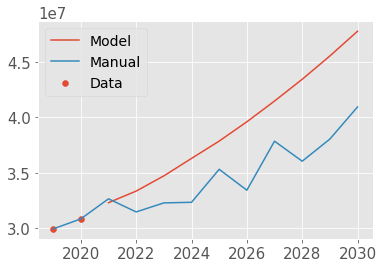

In [323]:
reg_pred = pd.DataFrame(np.zeros((10, len(reg_cols))), columns=reg_cols)
reg_pred["Government_"+"Social Democrats"] = 1
preds, pred_int = model.predict(n_periods=10, X = reg_pred, return_conf_int=True, alpha=0.05)

plt.scatter(data.Date[100:], data.NumberWords[100:], label = "Data")
plt.plot(np.arange(102, 112)+1919, np.exp(preds), label = "Model")
plt.plot(np.arange(100, 112)+1919, np.exp(y2[100:]), label = "Manual")
plt.legend()

### Significance of params

In [154]:
pd.DataFrame({"p-value":model.pvalues(), "significant" : model.pvalues() < 0.05})

,p-value,significant
intercept,5.943315e-02,False
Government_Conservative,8.227662e-01,False
Government_Independent,7.531424e-01,False
Government_Social Democrats,1.810469e-02,True
Government_Social Liberals,1.114436e-02,True
Government_Venstre,2.437308e-01,False
ar.L1,4.237540e-02,True
ar.L2,1.367107e-01,False
ar.L3,1.085830e-03,True
sigma2,1.006275e-31,True


In [60]:
sns.color_palette("Set1", n_colors = 5)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0)]

## Plot predictions

In [205]:
col = ["red", "green", "blue", "orange", "magenta"]
col = sns.color_palette("Set1", n_colors = 5)
gov_color = {gov : col[i] for i, gov in enumerate(government.unique())}

plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 14
plt.rcParams['legend.title_fontsize'] = 'large'
plt.rcParams["figure.titlesize"] = 25

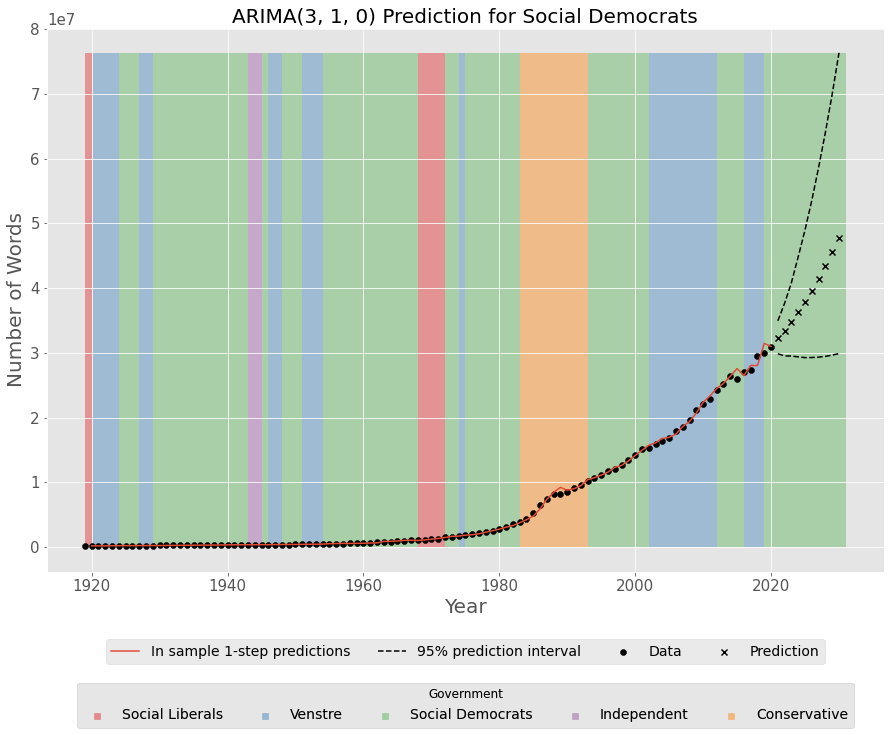

In [270]:
n_steps = 10
future_gov = "Social Democrats"



reg_pred = pd.DataFrame(np.zeros((n_steps, len(reg_cols))), columns=reg_cols)
reg_pred["Government_"+future_gov] = 1
preds, pred_int = model.predict(n_periods=n_steps, X = reg_pred, return_conf_int=True, alpha=0.05)
preds = np.exp(preds)
pred_int = np.exp(pred_int)

dates = np.arange(len(data.NumberWords)) + data.Date.min()

# plot 
fig, ax = plt.subplots(figsize = (15,10))

# set color rectangles to show government
h = max(data.NumberWords.max(), preds.max(), pred_int.max())

for i in range(len(dates)):
    ax.add_patch(Rectangle((dates[i],0), 1, h, alpha=0.4, color = gov_color[government[i]], lw = 0, zorder = 0))

for i in range(len(preds)):
    ax.add_patch(Rectangle((dates[-1]+i+1,0), 1, h, alpha=0.4, color = gov_color[future_gov], lw = 0, zorder = 0))

ax.scatter(dates, data.NumberWords, label = "Data", zorder = 1, color = "black")
ax.plot(dates[1:], np.exp(model.predict_in_sample(data[reg_cols][1:], start = 1, dynamic = False)), label = "In sample 1-step predictions", zorder = 2)
ax.scatter(dates[-1]+np.arange(1, n_steps+1), preds, label = "Prediction", zorder = 1, color = "black", marker = "x")
ax.plot(dates[-1]+np.arange(1, n_steps+1), pred_int[:, 0], label = "95% prediction interval", color = "black", linestyle = "--")
ax.plot(dates[-1]+np.arange(1, n_steps+1), pred_int[:, 1], color = "black", linestyle = "--")
# ax.vlines(dates[-1]+.5, 0, h, color = "black", linestyles = "dashed")
ax.set_ylabel("Number of Words")
ax.set_xlabel("Year")
ax.tick_params(axis="both")
ax.set_title(f"ARIMA{model.get_params().get('order')} Prediction for {future_gov}")
# ax.legend()
# ax.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0., fontsize = 14)
ax.legend(bbox_to_anchor=(0.5, -0.17), loc = 8, ncol = 4, borderaxespad=0)
ax.add_artist(ax.get_legend())
# ax.scatter(0,0, label ="test")
# ax.legend()
ax.add_artist(plt.legend(handles = [plt.scatter(x = None, y = None, alpha =.4, label=gov, color = gov_color[gov], marker="s") for gov in gov_color.keys()],
            loc = 8, title = "Government", bbox_to_anchor = (0.5, -0.3), ncol = 5)) # prev bbox = (0.01, 0.7)
# ax.vlines(dates[::4], 0, h, color = "black", linestyles = "dashed")


plt.savefig(f"figures/ARIMA{model.get_params().get('order')}_prediction_{future_gov}.pdf",  bbox_inches = "tight")

In [277]:
pred_int

# calculate confidence intervals
np.exp(np.log(preds[0]) + np.sqrt(sigma2)*1.96*np.array([-1,1])), pred_int[0]

(array([29855549.28460316, 34946760.49831689]),
 array([29855592.47476818, 34946709.94308661]))

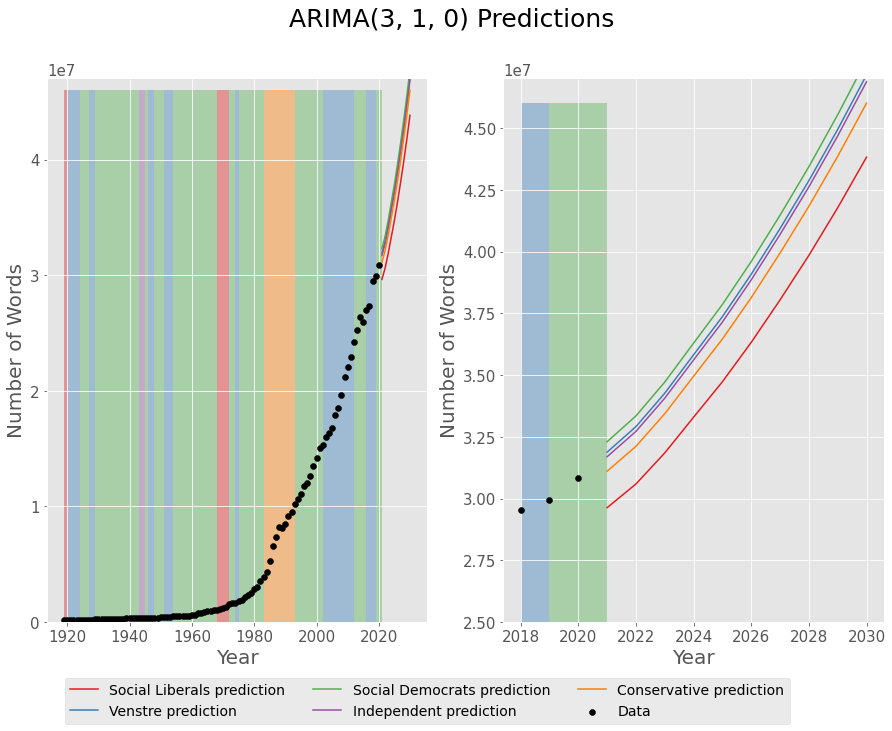

In [260]:
n_steps = 10
prev_steps = 3

# plot 
fig, ax = plt.subplots(1,2, figsize = (15,10))

dates = np.arange(len(data.NumberWords)) + data.Date.min()
# dates = dates[-prev_steps:]

for i, gov in enumerate(gov_color.keys()):
    reg_pred = pd.DataFrame(np.zeros((n_steps, len(reg_cols))), columns=reg_cols)
    reg_pred["Government_"+gov] = 1
    preds= model.predict(n_periods=n_steps, X = reg_pred)
    preds = np.exp(preds)
    ax[0].plot(dates[-1]+np.arange(1, n_steps+1), preds, label = gov + " prediction", zorder = 1, color = gov_color[gov])
    ax[1].plot(dates[-1]+np.arange(1, n_steps+1), preds, label = gov + " prediction", zorder = 1, color = gov_color[gov])
    # ax[1].scatter(dates[-1]+np.arange(1, n_steps+1), preds, zorder = 1, color = gov_color[gov], marker = "x")


# set color rectangles to show government
h0 = max(data.NumberWords.max(), preds.max())
h1 = max(data.NumberWords[-prev_steps:].max(), preds.max())

for i in range(len(dates)):
    ax[0].add_patch(Rectangle((dates[i],0), 1, h0, alpha=0.4, color = gov_color[government[i]], lw = 0, zorder = 0))
for i in range(prev_steps):
    ax[1].add_patch(Rectangle((dates[-prev_steps:][i],0), 1, h1, alpha=0.4, color = gov_color[government[len(government)-prev_steps+i]], lw = 0, zorder = 0))

ax[0].scatter(dates, data.NumberWords, label = f"Data", zorder = 1, color = "black")
ax[1].scatter(dates[-prev_steps:], data.NumberWords[-prev_steps:], label = f"Last {prev_steps} observations", zorder = 1, color = "black")

fig.suptitle(f"ARIMA{model.get_params().get('order')} Predictions")

ax[0].set_ylabel("Number of Words")
ax[0].set_xlabel("Year")
ax[0].set_ylim(0, h0+.1e7)

ax[1].set_ylabel("Number of Words")
ax[1].set_xlabel("Year")
ax[1].set_ylim(2.5e7, h1+.1e7)

ax[0].legend(ncol = 3, loc = 8, bbox_to_anchor = (1, -0.2))

plt.savefig(f"figures/ARIMA{model.get_params().get('order')}_predictions.pdf", bbox_inches = "tight")

## Plot residuals

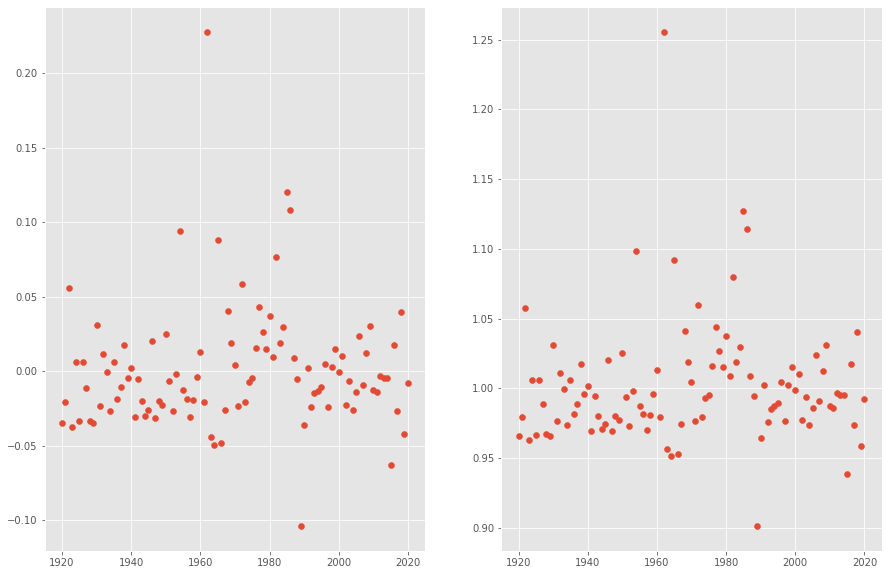

In [214]:
dates = np.arange(len(data.NumberWords)) + data.Date.min()

fig, ax = plt.subplots(1,2,figsize = (15,10))
ax[0].scatter(dates[1:], model.resid()[1:])
ax[1].scatter(dates[1:], np.exp(model.resid())[1:])

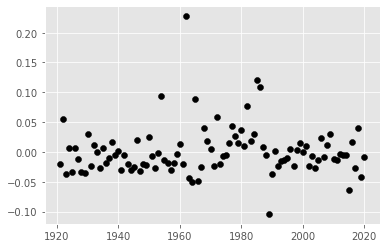

In [148]:
plt.scatter(preds.Date[1:], preds.NumberWordsLog[1:]-preds.model_preds[1:], label = "Residuals", zorder = 1, color = "black")

In [147]:
preds

,Date,NumberWordsLog,model_preds,manual_preds
1,NaN,NaN,12.081851,1.304350
2,1921.0,12.066333,12.087361,11.941260
3,1922.0,12.158693,12.102883,12.038978
4,1923.0,12.170207,12.207668,12.154376
5,1924.0,12.229530,12.223584,12.163591
...,...,...,...,...
97,2016.0,17.111316,17.094139,17.160282
98,2017.0,17.124454,17.151329,17.112899
99,2018.0,17.200697,17.160787,17.133275
100,2019.0,17.214419,17.256812,17.088810
